In [10]:
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{libertine}",
            r"\usepackage[libertine]{newtxmath}",
            r"\usepackage{inconsolata}",
        ]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x / 1000))


wandb.login()
api = wandb.Api()

In [2]:
tiny_lora = api.run("pico-lm/pico-relora/ixdq4sof")
small_lora = api.run("pico-lm/pico-relora/a8nvp3mi")
tiny_base = api.run("pico-lm/pico-relora/rpfgrgc4")
small_base = api.run("pico-lm/pico-relora/vmyjbapv")

In [3]:
data = {
    "lora": {
        "tiny": pd.DataFrame(tiny_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
    "base": {
        "tiny": pd.DataFrame(tiny_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
}

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_91467/3679100403.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)
/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_91467/3679100403.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)


In [4]:
def get_across_ranges(
    df: pd.DataFrame, metric_name: str, step_mod: int = 1, step_mod_offset: int = 0, *ranges
):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    df = df.drop_duplicates(subset=["_step"], inplace=False)
    mask = df["_step"] % step_mod == step_mod_offset
    df = df[mask]
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [5]:
STEP_MOD = 2_000

In [6]:
MODS = ("swiglu.w_2", "attention.v_proj", "attention.o_proj")

In [7]:
def _get_cn_data():
    for mod_idx, mod in enumerate(MODS):
        for t in data:
            for s in data[t]:
                metr_str = (
                    "condition_number_val/_forward_module.module.layers.{}"
                    + f".{mod}{'.lora' if t == 'lora' else ''}."
                    + ("weights" if t == "lora" else "gradients")
                )
                val = get_across_ranges(
                    data[t][s], metr_str, step_mod=2_000, step_mod_offset=0 if t == "base" else 100
                )
                for ckp_id, ckp in enumerate(val):
                    for lay_id, layer_val in enumerate(ckp):
                        yield (
                            [r"Swiglu $W_2$", r"Attention Value Projection", r"Attention Output Projection"][
                                mod_idx
                            ],
                            rf"\texttt{{pico-{'decoder' if t == 'base' else 'relora'}}}",
                            s,
                            int(ckp_id * 2),
                            lay_id,
                            layer_val,
                        )


cn_data = pd.DataFrame(
    _get_cn_data(),
    columns=["Component", "Model", "Scale", "Step", "Layer", "CondNum"],
)

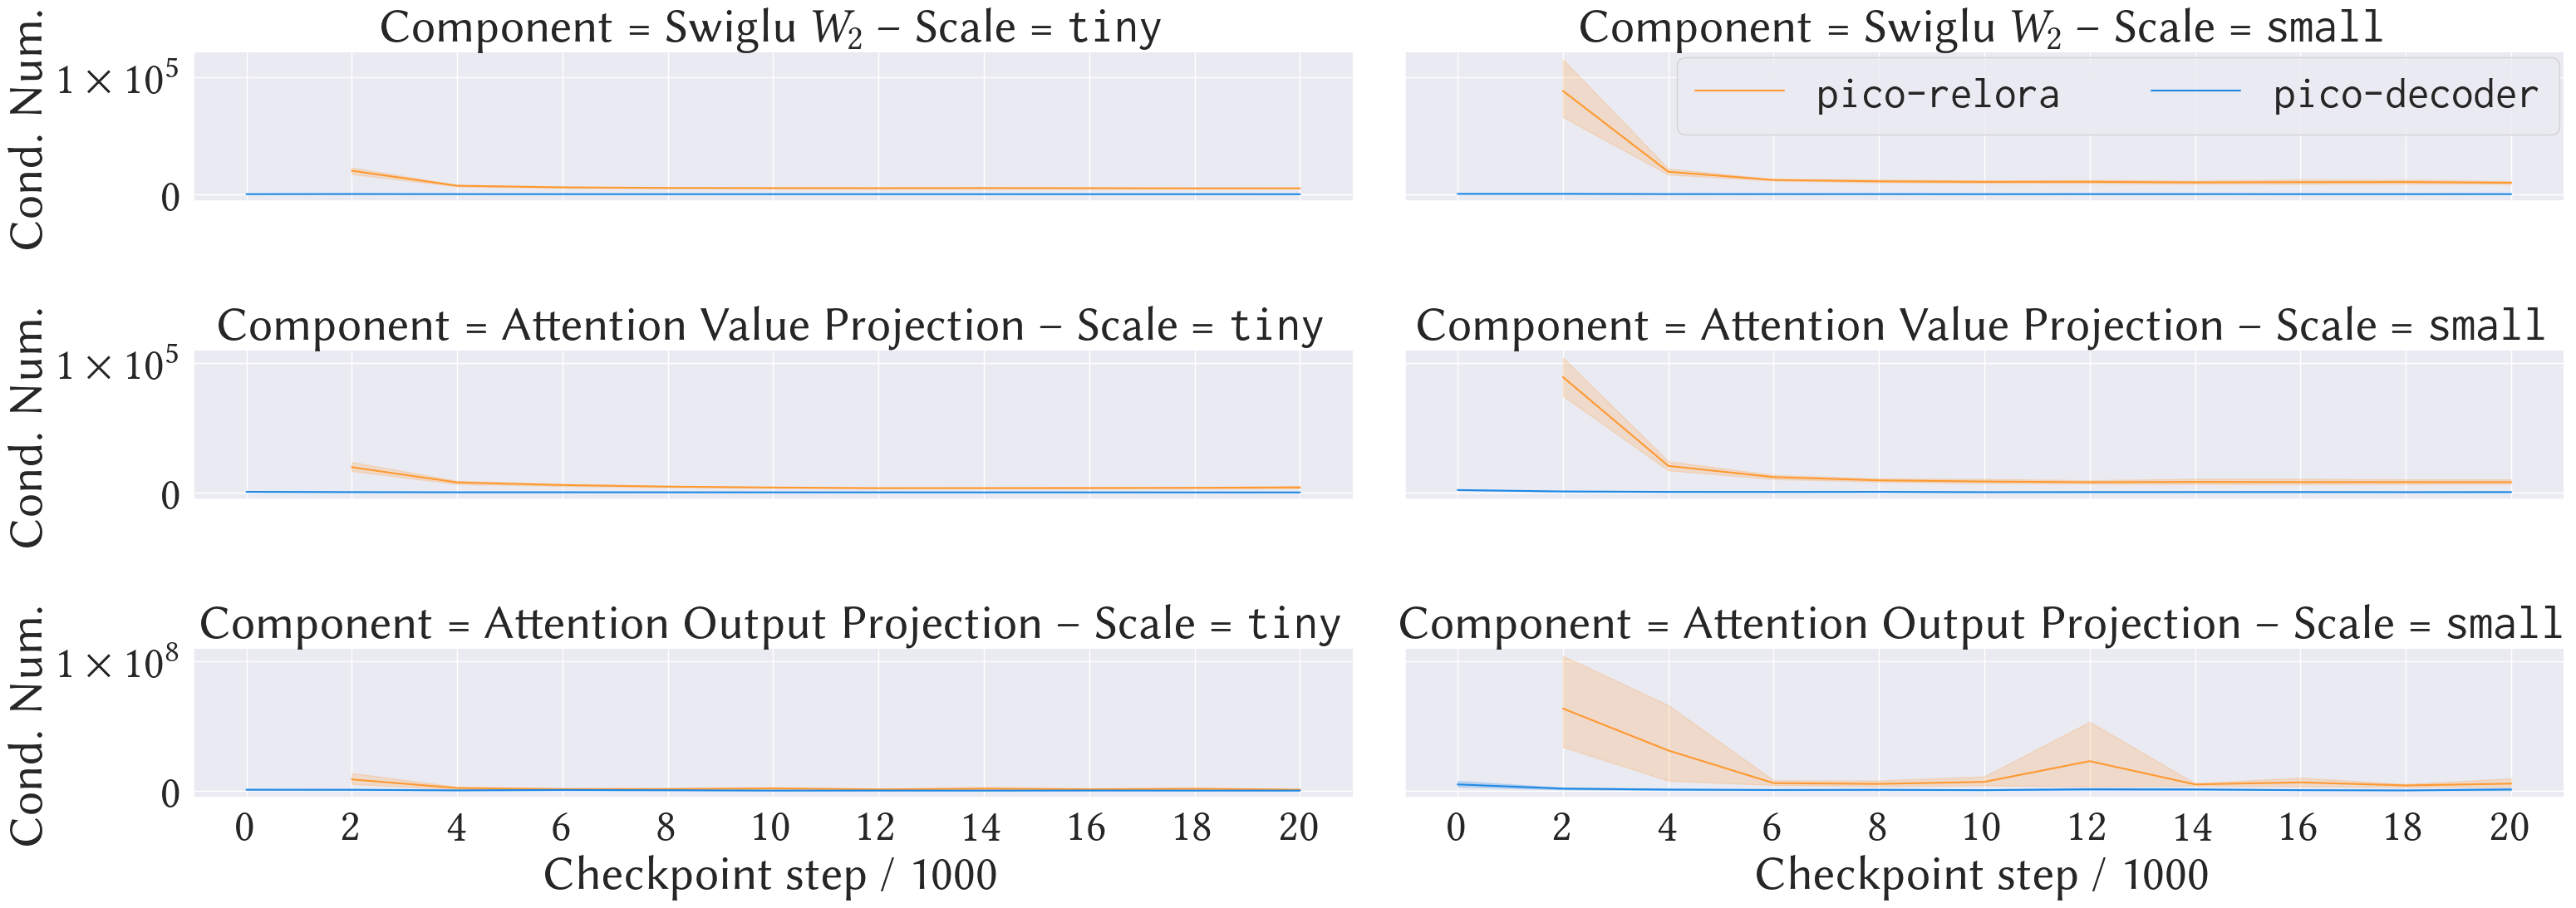

In [27]:
colors = ["#1E88E5", "#FF992F"]
models = sorted(cn_data["Model"].unique().tolist())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 3.5

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})


def format_scientific_0dp(number, _):
    if number == 0:
        return "0"
    exponent = int(f"{number:e}".split("e")[1])
    mantissa = round(number / (10**exponent))
    return rf"${mantissa} \times 10^{exponent}$"


g = sns.FacetGrid(
    data=cn_data,
    col="Scale",
    row="Component",
    height=4,
    aspect=4,
    sharey="row",
    sharex=True,
    margin_titles=False,
)

g.set_titles(template=r"Component = {row_name} -- Scale = \texttt{{{col_name}}}")


g.map_dataframe(sns.lineplot, x="Step", y="CondNum", hue="Model", palette=palette, markers=["s", "o"])


g.set_axis_labels("Checkpoint step / 1000", "Cond. Num.")

g.set_ylabels()

for idx, ax in enumerate(g.axes.flat):
    steps = cn_data["Step"].unique()
    ax.set_xticks(steps)
    ax.yaxis.set_major_formatter(FuncFormatter(format_scientific_0dp))
    if idx == 1:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper right", ncols=2, borderaxespad=0.1)

plt.savefig("../graphs/cn-grads.pdf", bbox_inches="tight")
plt.show()